#  Ensemble Learning (Bagging, Random Forest & Boosting) : Practice & Experiments

**Authored by Alexandre Mathias DONNAT, Sr - Télécom Paris**

This notebook covers ensemble learning methods for supervised learning, with a focus on variance reduction, model aggregation, and boosting techniques. It contains:

- Bagging fundamentals: theoretical motivation through majority voting with independent classifiers, followed by a practical implementation of Bagging for regression using decision trees of varying depth, illustrating bias–variance trade-offs and variance reduction through aggregation.

- Random Forests: evaluation of Random Forest models on multiple regression and classification datasets (Boston, Diabetes, Iris, Digits) using cross-validation, comparison with linear SVM baselines, visualization of class probability estimates in low-dimensional settings, and analysis of overfitting control through depth regularization.

- Boosting and AdaBoost: theoretical derivation of the exponential loss surrogate and its Bayes-optimal classifier, followed by an empirical study of AdaBoost on the Digits dataset, including cross-validation, learning curves (train/test error vs number of boosting iterations), and analysis of the impact of base learner complexity.

*It combines theoretical insights with empirical experiments to highlight the strengths and limitations of ensemble methods, and to illustrate how aggregation, randomness, and reweighting mechanisms improve generalization in practice.*

---


We consider a standard supervised learning problem. Given a training set $D = \{(X_1, Y_1), \ldots, (X_n, Y_n)\}$, an estimator/classifier is a function $\hat{f}_D$. If the $Y_i$ take their values in $\{1, \ldots, K\}$ we speak of a multi-class classification problem (with K classes) and if the $Y_i$ take their values in $\mathbb{R}$ we speak of a regression problem.

A model aggregation (classifiers/estimators) consists of combining (linearly) the individual predictions of each elementary model. In regression, we are interested in the model $\hat{F}^L_D$ obtained by aggregating L estimators $\hat{f}^l_D$, $l = 1, \cdots, L$:

$$\hat{F}^L_D = \sum_{l=1}^{L} w_l \hat{f}^l_D$$

where $w_l \geq 0$ are the weights.

For classification, aggregation can be done with a voting procedure (for example majority voting), or by averaging the class probabilities. If the prediction of a binary classifier $\hat{f}^l_D$ at $X$ corresponds to $\text{sign}(\hat{f}^l_D(X))$, then the aggregated model can also predict using $\text{sign}\left(\sum_{l=1}^{L} w_l \hat{f}^l_D(X)\right)$.

To illustrate this, let's consider L independent binary classifiers whose probability of predicting correctly is $p > 0.5$. Then the prediction of the aggregated model follows a Binomial distribution with parameters $p$ and $L$.

Q1) If $p$ = 0.7 (which is a prediction weakly above chance at 0.5) and $L$ = 1, 5, 10, 50, 100, what is the probability of correct prediction for the aggregated model? For $L$ = 10 chosen, plot the probabilities of correct classification for each number of classifiers 1, 2, ..., 10. We can use the implementation of the Binomial distribution in `scipy`:
```python
from scipy.stats import binom
rv = binom(L, p)
```
The problem in practice is that the data is provided only once. We must therefore find a way to generate randomness.


Answer : Let $K \sim \mathcal{B}(L,p)$ be the number of classifiers predicting correctly.
The aggregated classifier predicts correctly if a strict majority of classifiers is correct.
Therefore,
$$
\mathbb{P}(\text{correct prediction})
= \mathbb{P}\left(K > \frac{L}{2}\right)
+ \mathbf{1}_{L \text{ even}} \cdot \frac{1}{2}\mathbb{P}\left(K=\frac{L}{2}\right).$$

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.base import clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.svm import LinearSVR

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import LinearSVC

L=1, P(correct)=0.700000
L=5, P(correct)=0.836920
L=10, P(correct)=0.901191
L=50, P(correct)=0.998349
L=100, P(correct)=0.999984


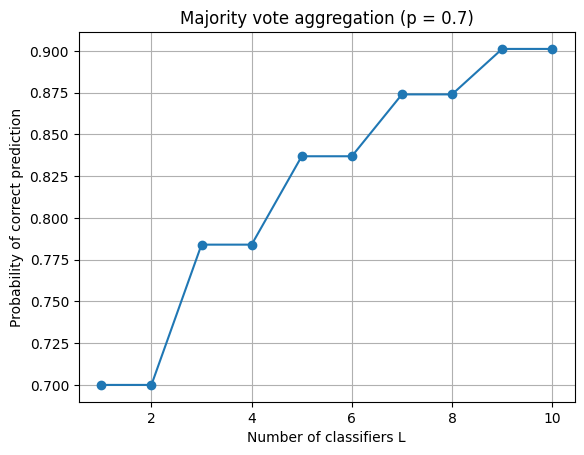

In [ ]:
def prob_correct_aggregation(p, L):
    rv = binom(L, p)
    half = L // 2
    prob = rv.sf(half) 
    if L % 2 == 0:
        prob += 0.5 * rv.pmf(half)  
    return prob

p = 0.7
Ls = [1, 5, 10, 50, 100]

for L in Ls:
    print(f"L={L}, P(correct)={prob_correct_aggregation(p, L):.6f}")

# Plot for L = 1..10
L_plot = np.arange(1, 11)
probs = [prob_correct_aggregation(p, L) for L in L_plot]

plt.figure()
plt.plot(L_plot, probs, marker='o')
plt.xlabel("Number of classifiers L")
plt.ylabel("Probability of correct prediction")
plt.title("Majority vote aggregation (p = 0.7)")
plt.grid(True)
plt.show()

For $p=0.7$, the probability of correct prediction increases rapidly with the number of classifiers.
For instance, it goes from $0.7$ for $L=1$ to more than $0.9$ for $L=10$, and is almost equal to $1$
for $L=50$ or $L=100$. This illustrates the benefit of aggregation under independence assumptions.


## 1. Bagging

Bagging (an acronym for "Bootstrap Aggregation") is a classical method for combining models. It consists of taking a simple average of the predictions, i.e., $w_l = 1/L$. In order to generate multiple estimators, we use several randomly generated datasets using the bootstrap. A bootstrap sample is a sample of $n$ training points obtained from $D$ by uniform random sampling (with replacement).


Q2) Implement Bagging with regression trees of depth 1 (stumps), then with deeper trees, starting from the code below. We can use BaggingRegressor.



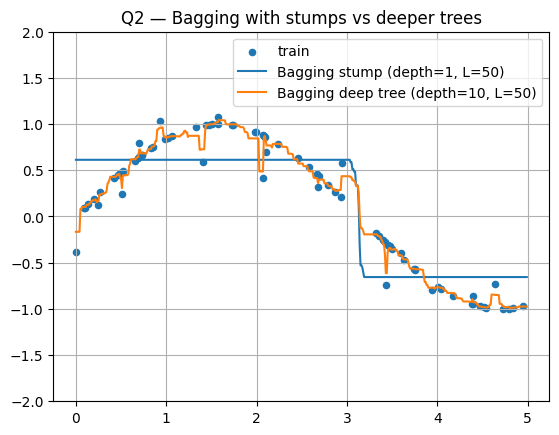

In [ ]:
# Create a random dataset (given)
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 * (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

def fit_bagging(max_depth, n_estimators=50, bootstrap=True, max_samples=1.0, random_state=0):
    base = DecisionTreeRegressor(max_depth=max_depth, random_state=random_state)
    model = BaggingRegressor(
        estimator=base,               
        n_estimators=n_estimators,
        bootstrap=bootstrap,
        max_samples=max_samples,
        random_state=random_state,
        n_jobs=-1
    )
    model.fit(X, y)
    return model

def plot_models(models, title):
    plt.figure()
    plt.scatter(X, y, s=20, label="train")
    for label, m in models:
        y_pred = m.predict(X_test)
        plt.plot(X_test, y_pred, label=label)
    plt.ylim(-2, 2)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

# Stump (depth=1) vs deeper trees
m_stump = fit_bagging(max_depth=1, n_estimators=50, bootstrap=True, random_state=1)
m_deep  = fit_bagging(max_depth=10, n_estimators=50, bootstrap=True, random_state=1)

plot_models(
    [("Bagging stump (depth=1, L=50)", m_stump),
     ("Bagging deep tree (depth=10, L=50)", m_deep)],
    "Q2 — Bagging with stumps vs deeper trees"
)

With decision stumps (depth = 1), the bagged model produces a piecewise constant and very coarse approximation of the underlying signal. Even when aggregating many estimators (L = 50), the prediction remains unable to capture the smooth sinusoidal shape of the data. This behavior indicates a **high bias** model: the estimator is too simple and underfits the data.

In contrast, using deeper trees (depth = 10) significantly increases the flexibility of the base learners. The aggregated prediction follows the global structure of the signal much more closely while remaining relatively smooth thanks to averaging. This illustrates that bagging can effectively exploit **low-bias but high-variance** estimators by stabilizing their predictions through aggregation.

Q3) Graphically illustrate the role of L (number of estimators) as well as the tree depth (max_depth) by varying these two parameters.


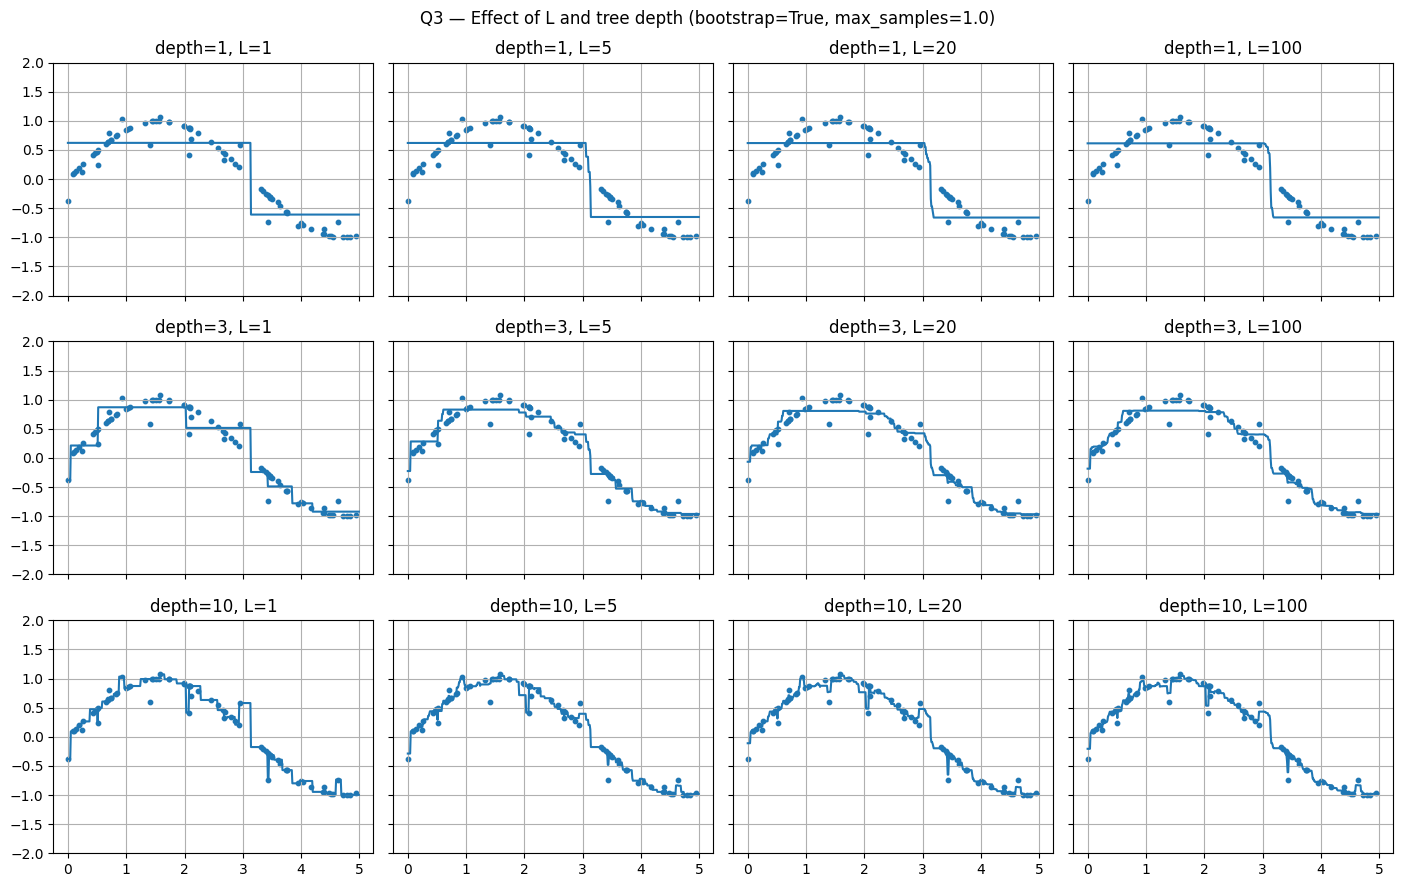

In [7]:
def plot_grid(L_values, depth_values, bootstrap=True, max_samples=1.0, random_state=1):
    fig, axes = plt.subplots(len(depth_values), len(L_values), figsize=(3.5*len(L_values), 3*len(depth_values)), sharex=True, sharey=True)
    for i, d in enumerate(depth_values):
        for j, L in enumerate(L_values):
            model = fit_bagging(max_depth=d, n_estimators=L, bootstrap=bootstrap, max_samples=max_samples, random_state=random_state)
            ax = axes[i, j] if len(depth_values) > 1 else axes[j]
            ax.scatter(X, y, s=10)
            ax.plot(X_test, model.predict(X_test))
            ax.set_title(f"depth={d}, L={L}")
            ax.grid(True)
    plt.suptitle(f"Q3 — Effect of L and tree depth (bootstrap={bootstrap}, max_samples={max_samples})")
    plt.ylim(-2, 2)
    plt.tight_layout()
    plt.show()

L_values = [1, 5, 20, 100]
depth_values = [1, 3, 10]
plot_grid(L_values, depth_values, bootstrap=True, max_samples=1.0, random_state=1)

For a fixed tree depth, increasing the number of estimators L mainly reduces the variability of the prediction. When L is small (e.g. L = 1 or 5), the model exhibits noticeable irregularities due to the variance of individual trees. As L increases, the aggregated predictor becomes progressively smoother and more stable, while its global shape remains unchanged. This shows that bagging primarily acts as a **variance reduction mechanism**.

Regarding tree depth, shallow trees (depth = 1) yield stable but strongly biased predictions, which do not improve significantly when L increases. Increasing the depth reduces the bias and allows the model to better approximate the underlying function, but also increases variance for small L. Bagging mitigates this effect by averaging many deep trees, leading to accurate and stable predictions when both depth and L are sufficiently large.

These plots highlight the classical **bias–variance trade-off**: model complexity (tree depth) controls bias, while bagging (increasing L) controls variance.


Q4) How can we recognize that the estimators built by the trees are biased and that bagging reduces their variance?

- **Bias (stumps / small depth):** The prediction is too "rigid" (very coarse piecewise constant function), failing to follow the sinusoidal curve → systematic error even when L increases.

- **Variance (deep trees):** A single tree (or small L) produces a very irregular curve, sensitive to noise → bagging (L↑) smooths and stabilizes: fewer oscillations.


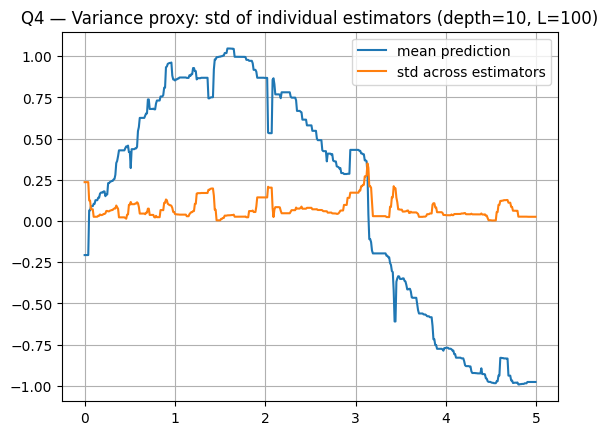

In [8]:
def pred_std_across_estimators(model, X_grid):
    # predictions from each base estimator
    preds = np.vstack([est.predict(X_grid) for est in model.estimators_])
    return preds.std(axis=0), preds.mean(axis=0)

m = fit_bagging(max_depth=10, n_estimators=100, bootstrap=True, random_state=1)
std_pred, mean_pred = pred_std_across_estimators(m, X_test)

plt.figure()
plt.plot(X_test, mean_pred, label="mean prediction")
plt.plot(X_test, std_pred, label="std across estimators")
plt.title("Q4 — Variance proxy: std of individual estimators (depth=10, L=100)")
plt.grid(True)
plt.legend()
plt.show()

The standard deviation of the predictions across individual estimators provides a proxy for the variance of the base learners. For deep trees (depth = 10), this variance is non-negligible and varies across the input space, with higher values in regions where the prediction changes abruptly.

Despite this variability at the level of individual estimators, the mean aggregated prediction remains smooth and stable. This illustrates that while each deep tree is a high-variance estimator, bagging effectively reduces variance through averaging, without increasing bias.

Q5) By varying the noise level, demonstrate overfitting.

We will parameterize the noise level and compare a "simple" model vs a "complex" model.



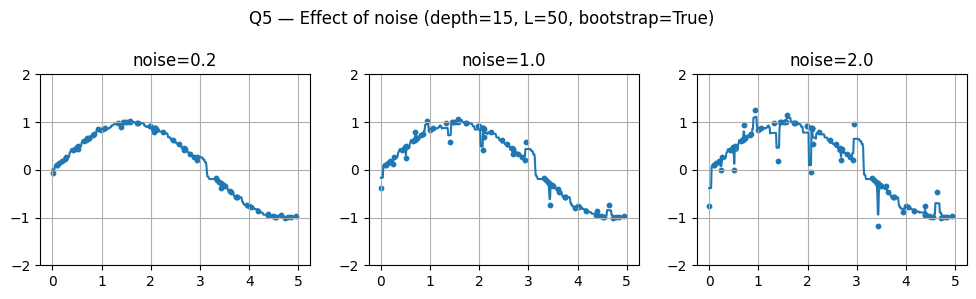

In [ ]:
def make_data(noise_scale=1.0, seed=1):
    rng = np.random.RandomState(seed)
    X = np.sort(5 * rng.rand(80, 1), axis=0)
    y = np.sin(X).ravel()
    y[::5] += noise_scale * (0.5 - rng.rand(16))
    return X, y

def run_noise_experiment(noise_values, max_depth, L=50, bootstrap=True, max_samples=1.0, seed=1):
    global X, y 
    plt.figure(figsize=(10, 3))
    for k, noise in enumerate(noise_values, 1):
        X, y = make_data(noise_scale=noise, seed=seed)
        model = fit_bagging(max_depth=max_depth, n_estimators=L, bootstrap=bootstrap, max_samples=max_samples, random_state=seed)
        plt.subplot(1, len(noise_values), k)
        plt.scatter(X, y, s=10)
        plt.plot(X_test, model.predict(X_test))
        plt.title(f"noise={noise}")
        plt.ylim(-2, 2)
        plt.grid(True)
    plt.suptitle(f"Q5 — Effect of noise (depth={max_depth}, L={L}, bootstrap={bootstrap})")
    plt.tight_layout()
    plt.show()

# Compare a deep model under increasing noise
run_noise_experiment(noise_values=[0.2, 1.0, 2.0], max_depth=15, L=50, bootstrap=True, max_samples=1.0, seed=1)

When the noise level is low, the bagged model with deep trees accurately captures the underlying sinusoidal structure of the data. As the noise level increases, the training points become more scattered and the individual trees tend to fit noise-induced fluctuations.

This results in increasingly irregular predictions, especially in regions with sparse data. These effects are characteristic of **overfitting**, where model flexibility allows noise to be captured as signal. The phenomenon becomes more pronounced as the noise level increases.

Q6) Observe that we can reduce this phenomenon by random subsampling (without replacement) instead of taking bootstrap samples.



Here, I compare: `bootstrap=True` (sampling with replacement) vs `bootstrap=False` + `max_samples < 1.0` (sampling without replacement, subsampling)

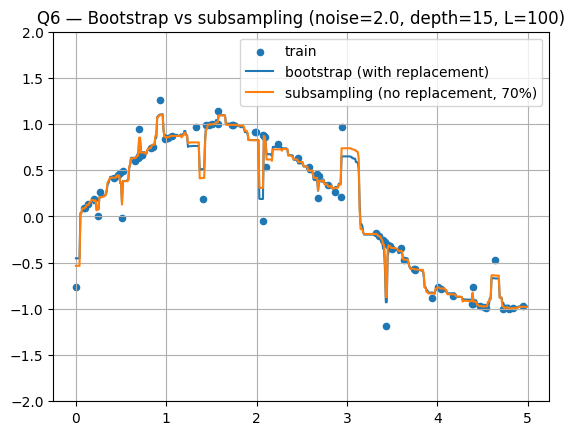

In [11]:
# Fix a noisy dataset to emphasize the effect
X, y = make_data(noise_scale=2.0, seed=1)

m_boot = fit_bagging(max_depth=15, n_estimators=100, bootstrap=True,  max_samples=1.0, random_state=1)
m_sub  = fit_bagging(max_depth=15, n_estimators=100, bootstrap=False, max_samples=0.7, random_state=1)

plot_models(
    [("bootstrap (with replacement)", m_boot),
     ("subsampling (no replacement, 70%)", m_sub)],
    "Q6 — Bootstrap vs subsampling (noise=2.0, depth=15, L=100)"
)

When using bootstrap sampling (with replacement), individual trees may see duplicated observations, which increases their sensitivity to noisy points and leads to more pronounced local irregularities in the aggregated prediction.

By contrast, subsampling without replacement reduces the influence of duplicated noisy observations and increases diversity among the base learners. As a result, the aggregated prediction is smoother and less sensitive to noise, illustrating a reduction of overfitting compared to standard bootstrap aggregation.

## 2. Random Forest

Random Forests combine the idea of Bagging—bootstrap sampling and averaging—with random selection of features at each node during tree construction. In the case of classification, aggregation is done by majority voting.



Q7) 7-fold CV: Random Forest vs SVM Linear (boston, diabetes, iris, digits)

In [ ]:
# Load datasets
from sklearn.datasets import load_diabetes, load_iris, load_digits
# Regression datasets
diabetes = load_diabetes()
X_diab, y_diab = diabetes.data, diabetes.target

# Boston
try:
    from sklearn.datasets import load_boston
    boston = load_boston()
    X_bos, y_bos = boston.data, boston.target
    boston_name = "boston (load_boston)"
except Exception:
    from sklearn.datasets import fetch_openml
    boston = fetch_openml(name="boston", as_frame=False)
    X_bos, y_bos = boston.data, boston.target.astype(float)
    boston_name = "boston (OpenML)"
# Classification datasets
iris = load_iris()
X_iris, y_iris = iris.data, iris.target

digits = load_digits()
X_dig, y_dig = digits.data, digits.target

# CV setup
cv7 = KFold(n_splits=7, shuffle=True, random_state=1)

def eval_regression(X, y, name):
    rf = RandomForestRegressor(n_estimators=300, random_state=1, n_jobs=-1)
    svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVR(random_state=1))
    ])
    rf_scores  = cross_val_score(rf,  X, y, cv=cv7, scoring="r2")
    svm_scores = cross_val_score(svm, X, y, cv=cv7, scoring="r2")
    print(f"[REG] {name:18s} | RF R2 = {rf_scores.mean():.3f} ± {rf_scores.std():.3f} | LinearSVM R2 = {svm_scores.mean():.3f} ± {svm_scores.std():.3f}")

def eval_classification(X, y, name):
    rf = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=-1)
    svm = Pipeline([
        ("scaler", StandardScaler()),
        ("svm", LinearSVC(random_state=1))
    ])
    rf_scores  = cross_val_score(rf,  X, y, cv=cv7, scoring="accuracy")
    svm_scores = cross_val_score(svm, X, y, cv=cv7, scoring="accuracy")
    print(f"[CLS] {name:18s} | RF acc = {rf_scores.mean():.3f} ± {rf_scores.std():.3f} | LinearSVM acc = {svm_scores.mean():.3f} ± {svm_scores.std():.3f}")

# Run evaluations
eval_regression(X_bos, y_bos, boston_name)
eval_regression(X_diab, y_diab, "diabetes")

eval_classification(X_iris, y_iris, "iris")
eval_classification(X_dig, y_dig, "digits")

[REG] boston (OpenML)    | RF R2 = 0.867 ± 0.090 | LinearSVM R2 = 0.676 ± 0.144
[REG] diabetes           | RF R2 = 0.396 ± 0.131 | LinearSVM R2 = 0.340 ± 0.102
[CLS] iris               | RF acc = 0.946 ± 0.053 | LinearSVM acc = 0.920 ± 0.041
[CLS] digits             | RF acc = 0.977 ± 0.005 | LinearSVM acc = 0.955 ± 0.015


Across all datasets, Random Forests consistently outperform linear SVMs.

For regression, the improvement is particularly clear on the Boston dataset, where the Random Forest achieves a substantially higher $R^2$ score ($0.867 \pm 0.090$) compared to the linear SVM ($0.676 \pm 0.144$). This indicates that Random Forests are better suited to capture the non-linear relationships present in the data. On the diabetes dataset, the improvement is more moderate but still consistent, with Random Forests achieving a higher average $R^2$.

For classification, Random Forests also outperform linear SVMs on both datasets. On Iris, the accuracy increases from $0.920$ to $0.946$, and on Digits from $0.955$ to $0.977$, with a notably smaller variance across folds for Random Forests. These results highlight the robustness and expressive power of Random Forests compared to linear models, especially when the underlying decision boundaries are non-linear.

*Random Forests, like Bagging, can be used to predict probabilities. To do this, the probability of being in class k is the proportion of trees that predict class k.*

Q8) Using the iris dataset restricted to the first two explanatory variables, display the prediction probabilities for each class.

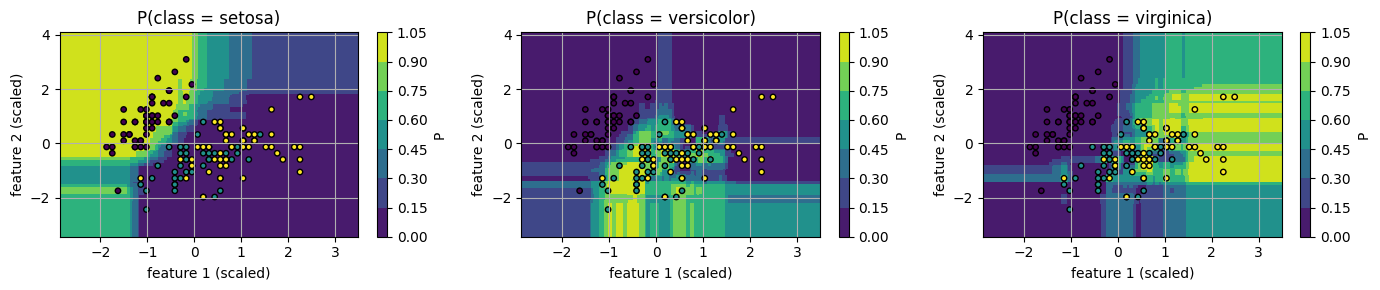

In [ ]:
# Load data
iris = load_iris()
X_unscaled, y = iris.data[:, :2], iris.target

# Standardize
X = preprocessing.scale(X_unscaled)

rf = RandomForestClassifier(n_estimators=300, random_state=1, n_jobs=-1)
rf.fit(X, y)

# Meshgrid
h = 0.02
x_min, x_max = X[:, 0].min() - 1.0, X[:, 0].max() + 1.0
y_min, y_max = X[:, 1].min() - 1.0, X[:, 1].max() + 1.0
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
grid = np.c_[xx.ravel(), yy.ravel()]

proba = rf.predict_proba(grid).reshape(xx.shape[0], xx.shape[1], -1)

# Plot: one subplot per class probability
plt.figure(figsize=(14, 3))
for k in range(3):
    plt.subplot(1, 3, k+1)
    contour = plt.contourf(xx, yy, proba[:, :, k], cmap='viridis')
    plt.colorbar(contour, label=f'P')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=15, edgecolors="k")
    plt.title(f"P(class = {iris.target_names[k]})")
    plt.xlabel("feature 1 (scaled)")
    plt.ylabel("feature 2 (scaled)")
    plt.grid(True)

plt.tight_layout()
plt.show()

The probability maps show how Random Forests provide smooth and interpretable class probabilities. Regions where one class dominates are characterized by probabilities close to one, indicating strong agreement among the trees. These areas correspond to well-separated regions of the feature space.

Near the decision boundaries, the predicted probabilities become more diffuse, reflecting disagreement among the individual trees. This uncertainty is particularly visible in transition regions between classes, where no single class clearly dominates. These plots illustrate how Random Forests naturally quantify prediction uncertainty through class probabilities, rather than providing only hard class assignments.

Q9) Compare the scores by 6-fold cross-validation of Random Forests and pure decision trees (obtained with DecisionTreeClassifier), on the digits dataset. Vary the max_depth parameter between 1 and 15. Highlight the fact that Random Forests reduce overfitting, even for deep trees.


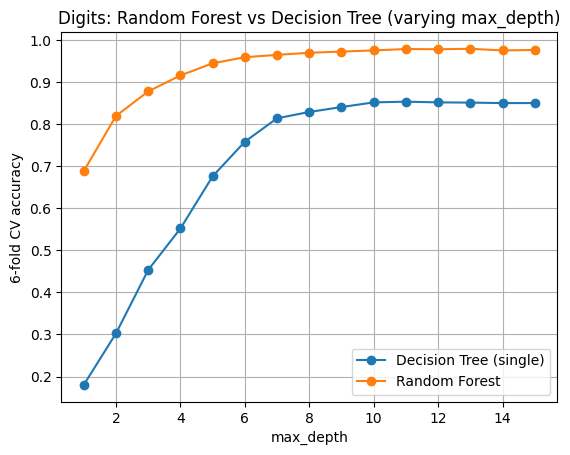

In [ ]:
digits = load_digits()
X, y = digits.data, digits.target

cv6 = KFold(n_splits=6, shuffle=True, random_state=1)

depths = np.arange(1, 16)
tree_scores = []
rf_scores = []

for d in depths:
    tree = DecisionTreeClassifier(max_depth=d, random_state=1)
    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=d,            
        max_features="sqrt",
        bootstrap=True,
        random_state=1,
        n_jobs=-1
    )
    tree_scores.append(cross_val_score(tree, X, y, cv=cv6, scoring="accuracy").mean())
    rf_scores.append(cross_val_score(rf, X, y, cv=cv6, scoring="accuracy").mean())

plt.figure()
plt.plot(depths, tree_scores, marker="o", label="Decision Tree (single)")
plt.plot(depths, rf_scores, marker="o", label="Random Forest")
plt.xlabel("max_depth")
plt.ylabel("6-fold CV accuracy")
plt.title("Digits: Random Forest vs Decision Tree (varying max_depth)")
plt.grid(True)
plt.legend()
plt.show()

For a single decision tree, increasing the maximum depth initially improves performance, but the cross-validation accuracy quickly saturates and remains significantly below that of the Random Forest. This behavior reflects the strong variance of deep decision trees, which tend to overfit the training data despite increased complexity.

In contrast, the Random Forest achieves high accuracy even for small depths and continues to improve or stabilize as depth increases. Crucially, its performance remains consistently superior to that of a single tree for all depths considered. This demonstrates that Random Forests effectively reduce overfitting through aggregation and random feature selection, allowing the use of deep, expressive trees without suffering from excessive variance.

## 3. Boosting

From a historical perspective, one of the first Boosting algorithms to achieve real success is called "AdaBoost.M1" and was proposed by Freund and Schapire.

## *Theory*

We consider the framework of binary classification: the labels take two possible values: $-1$ and $1$. We seek a 'good' regression function $\hat{f} : x \mapsto \hat{f}(x) \in \mathbb{R}$, and we take as the associated classifier $\hat{h}(x) = \text{sign}(\hat{f}(x))$. Recall that we denote by $\eta$ the regression function $\eta(x) = \mathbb{P}(Y = 1 \mid X = x)$.

The reference cost is the 0/1 loss which is written as

$$\text{loss}(x, y, f) = \mathbf{1}_{\{-y f(x) \geq 0\}} = \varphi_0(-y f(x)),$$

where $\varphi_0$ is the indicator function $\varphi_0 = \mathbf{1}_{\mathbb{R}_+}$. We recall that the Bayes classifier associated with the problem is $h^*_{\varphi_0} = \text{sign}(2\eta - 1)$. By definition, the Bayes classifier minimizes the classification risk

$$R_{\varphi_0}(h) = \mathbb{P}(Y \neq h(X)) = \mathbb{P}(-Y f(X) \geq 0) = \mathbb{E}(\varphi_0[-Y f(X)]).$$

Depending on the context, we will write $R_\varphi(f)$ or $R_\varphi(h)$ to denote the same risk. Thus,

$$h^*_{\varphi_0} = \arg \min_h R_{\varphi_0}(h) = \text{sign}(2\eta - 1),$$

where the min is taken over all measurable functions, which can be written as

$$h^*_{\varphi_0} = \arg \min_{h:\mathbb{R}^d \to \{-1,1\}} R_{\varphi_0}(h), \quad \text{where} \quad R_{\varphi_0}(h) = \mathbb{E}(\varphi_0[-Y f(X)]).$$

In practice, we do not have access to the unknown distribution of the joint law of the observations. We therefore seek to optimize the empirical counterpart of the risk. The minimizer of the empirical risk is then

$$\hat{f}_{n,\varphi_0} = \arg \min_f R_{n,\varphi_0}(f), \quad \text{where} \quad R_{n,\varphi_0}(f) = \mathbb{E}_n(\varphi_0[-Y f(X)]) = \frac{1}{n} \sum_{i=1}^{n} \varphi_0(-Y_i f(X_i)),$$

and the associated classifier is therefore $\hat{h}_{n,\varphi_0} = \text{sign}(\hat{f}_{n,\varphi_0})$.

The main problem with the function $\varphi_0$ is that it is not convex, which makes its optimization difficult. We will therefore use "convex surrogates," that is, well-chosen functions $\varphi$, convex, and "close" to $\varphi_0$.


Q10) Prove the following property: "The minimizer of the function $f \mapsto R_{\exp}(f) = \mathbb{E}(\exp(-Y f(X)))$ is achieved at $f^*_{\exp} = \frac{1}{2} \log\left(\frac{\eta(X)}{1-\eta(X)}\right)$."


We consider the exponential risk:

$$R_{\exp}(f) = \mathbb{E}[\exp(-Yf(X))]$$

As always in classification theory, we reason point-wise at $x$ via the conditional risk.

#### Step 1 - Conditional risk at a point $x$

Fix $x$. Let:

$$\eta(x) = \mathbb{P}(Y=1 \mid X=x)$$

Then:

$$\begin{align}
R_{\exp}(f \mid X=x) &= \mathbb{E}[\exp(-Yf(x)) \mid X=x] \\
&= \eta(x) e^{-f(x)} + (1-\eta(x)) e^{f(x)}
\end{align}$$

We seek to minimize this quantity in $f(x) \in \mathbb{R}$.

##### Step 2 - Explicit minimization

Consider the function:

$$g(t) = \eta e^{-t} + (1-\eta) e^{t}$$

It is:
- strictly convex
- differentiable

therefore its minimum is given by setting the derivative to zero.

Computing the derivative:

$$g'(t) = -\eta e^{-t} + (1-\eta) e^{t}$$

Minimum condition:

$$g'(t) = 0 \Longleftrightarrow (1-\eta) e^{t} = \eta e^{-t}$$

Hence:

$$e^{2t} = \frac{\eta}{1-\eta} \Longleftrightarrow t = \frac{1}{2}\log\left(\frac{\eta}{1-\eta}\right)$$

##### Result 

We obtain:

$$f_{\exp}^*(x) = \frac{1}{2}\log\left(\frac{\eta(x)}{1-\eta(x)}\right)$$

which proves the required property.


Q11) Deduce that the Bayes classifier associated with the risk $R_{\exp}$ is the same as the Bayes classifier associated with the 0/1 risk, $R_{\varphi_0}$.


The associated classifier is:

$$\hat{h}_{\exp}(x) = \text{sign}(f_{\exp}^*(x))$$

Now:

$$\text{sign}\left(\frac{1}{2}\log\frac{\eta(x)}{1-\eta(x)}\right) = \text{sign}\left(\eta(x) - \frac{1}{2}\right)$$

Therefore:

$$\hat{h}_{\exp}(x) = \text{sign}(2\eta(x) - 1)$$

The Bayes classifier associated with the exponential risk $R_{\exp}$ coincides exactly with the Bayes classifier associated with the 0/1 risk:

$$h_{\exp}^* = h_{\phi_0}^*$$

The exponential risk is therefore a consistent convex surrogate of the 0/1 classification risk.


## *AdaBoost*

This method consists of finding solutions to an optimization problem where we restrict the possible choices of candidates. Suppose we start with M expert classifiers available, or equivalently that we have $f_1, \ldots, f_M$. A natural objective is then to find the best possible combination of classifiers, thus solving the following program:

$$\hat{f}_{M,n,\varphi} = \arg\min_{f \in \text{Conv}(f_1,\ldots,f_M)} R_{n,\varphi}(f), \text{ where } \varphi_0 \leq \varphi \text{ and } \varphi \text{ is convex.}$$

with the notation: 

$$\text{Conv}(f_1, \ldots, f_M) = \left\{f : \exists(\alpha_1, \ldots, \alpha_M) \in \mathbb{R}_+^M, \sum_{j=1}^M \alpha_j = 1, \text{ s.t. } f = \sum_{j=1}^M \alpha_j f_j\right\}.$$

The AdaBoost algorithm is based on this principle (except that the expert classifiers are also updated during the algorithm). It aims to minimize a convexified version $R_{n,\exp}$ of the empirical risk corresponding to the exponential loss function.

For $w \in \mathbb{R}^n$, we will use the notation $P_{n,w}$ to denote the discrete probability with weights $w$: 

$$P_{n,w} = \frac{1}{n}\sum_{i=1}^n w_i \delta_{X_i},$$

and $E_{n,w}$ the associated expectation, for example $E_{n,w}(f(X)) = \frac{1}{n}\sum_{i=1}^n w_i f(X_i)$.

---

**Algorithm 1: AdaBoost**

---

**Data:** observations and their labels $D_n = \{(X_i, Y_i) : 1 \leq i \leq n\}$, number of steps $M$, a weight vector $w^0 \in \mathbb{R}^n$ (generally we choose $w_i^0 = \frac{1}{n}$ for all $i \in \{1, \ldots, n\}$)

**Result:** a classifier $\hat{h}_M^{\text{boost}}$

**for** $m = 1, \ldots, M$ **do**

• Fit a classifier $\hat{h}_m$ with a distribution of observations according to the weight vector $w^{m-1} = (w_1^{m-1}, \ldots, w_n^{m-1})$

• Compute: 
$$P_{w^{m-1}}(Y \neq \hat{h}_m(X)) = \sum_{i=1}^n w_i^{m-1} \mathbf{1}_{\{Y_i \neq \hat{h}_m(X_i)\}}$$

$$P_{w^{m-1}}(Y = \hat{h}_m(X)) = \sum_{i=1}^n w_i^{m-1} \mathbf{1}_{\{Y_i = \hat{h}_m(X_i)\}}$$

$$c_m = \frac{1}{2} \log \left[\frac{P_{w^{m-1}}(Y = \hat{h}_m(X))}{P_{w^{m-1}}(Y \neq \hat{h}_m(X))}\right]$$

• Update the weights:

$$w_i^{\text{int}} = w_i^{m-1} \exp\left(2 \cdot c_m \cdot \mathbf{1}_{\{Y_i \neq \hat{h}_m(X_i)\}}\right)$$

$$w_i^m = \frac{w_i^{\text{int}}}{\sum_{j=1}^n w_j^{\text{int}}}$$

**end for**

**return** 
$$\hat{h}_M^{\text{boost}} = \text{sign}\left(\sum_{m=1}^M c_m \hat{h}_m\right)$$

---

**Remark:** The algorithm increases the weight of observations that are misclassified (i.e., $Y_i \neq h_m(X_i)$) by the $m$-th expert so that we pay more attention to them at the next step.

We can explain the choice of weighting coefficients as follows: having already available a regressor $\hat{F}_{m-1} = \sum_{k=1}^{m-1} c_k \hat{h}^k$, the classifier obtained if we stopped at step $m$ would be

$$\hat{h}_m^{\text{boost}} = \text{sign}\left(\sum_{k=1}^{m-1} c_k \hat{h}^k + c_m \hat{h}_m\right),$$

We seek to construct a new weight $c$ for the new contribution $\hat{h}_m$ so as to minimize the exp-risk of $\hat{h}_m^{\text{boost}}$. We therefore want to obtain the solution of the following program

$$c_m^* = \arg\min_{c \in \mathbb{R}} \mathbb{E}\left[\exp\left(-Y\left(\sum_{k=1}^{m-1} c_k \hat{h}^k(X) + c \cdot \hat{h}_m(X)\right)\right)\right].$$

But since $\mathbb{E}$ is unknown, we instead seek a reformulation using the empirical counterpart:

$$c_m^* = \arg\min_{c \in \mathbb{R}} E_n\left[\exp\left(-Y\left(\sum_{k=1}^{m-1} c_k \hat{h}^k(X) + c \cdot \hat{h}_m(X)\right)\right)\right].$$

Noting $\hat{F}_{m-1} = \sum_{k=1}^{m-1} c_k \hat{h}^k$, the problem becomes

$$\arg\min_{c \in \mathbb{R}} E_n\left[\exp\left(-Y\left(\hat{F}_{m-1}(X) + c \cdot \hat{h}_m(X)\right)\right)\right] = \arg\min_{c \in \mathbb{R}} E_{w^{m-1}}\left[\exp(-c \cdot Y \cdot \hat{h}_m(X))\right]$$

where $w_i^{m-1} \propto \exp\left(-Y_i \hat{F}_{m-1}(X_i)\right)$.


Q12) Show that the solution of the last optimization program is: $c_m = \frac{1}{2} \log \left[\frac{P_{w^{m-1}}(Y = \hat{h}_m(X))}{P_{w^{m-1}}(Y \neq \hat{h}_m(X))}\right]$.


We start from the program (with the weighted distribution $w^{m-1}$):

$$c_m^* = \arg\min_{c \in \mathbb{R}} \mathbb{E}_{w^{m-1}}[\exp(-c Y h_m(X))].$$

Since $Y h_m(X) \in \{-1, +1\}$, let:

$$A = P_{w^{m-1}}(Y = h_m(X)), \quad B = P_{w^{m-1}}(Y \neq h_m(X)).$$

Then

$$\mathbb{E}_{w^{m-1}}[\exp(-c Y h_m(X))] = A e^{-c} + B e^c.$$

Minimization with respect to $c$: zero derivative

$$\frac{d}{dc}(A e^{-c} + B e^c) = -A e^{-c} + B e^c = 0 \iff B e^c = A e^{-c} \iff e^{2c} = \frac{A}{B}.$$

Therefore

$$c_m = \frac{1}{2} \log\left(\frac{A}{B}\right) = \frac{1}{2} \log\left(\frac{P_{w^{m-1}}(Y = h_m(X))}{P_{w^{m-1}}(Y \neq h_m(X))}\right).$$


Q13) Show that the weights $\omega_i^m \propto \omega_i^{m-1} \cdot \exp(-c_m^* \cdot Y_i \cdot \hat{h}_m(X_i))$ (where $c_m^*$ is defined above) and the weights $w_i^m \propto w_i^{m-1} \cdot \exp(2 \cdot c_m \cdot \mathbf{1}_{\{Y_i \neq \hat{h}_m(X_i)\}})$ (where $c_m$ is defined in the AdaBoost algorithm) are identical, with the convention $\hat{F}_0 = 0$ and $w^0 = \omega^0 = \left(\frac{1}{n}, \ldots, \frac{1}{n}\right)$.



We have:

$$\omega_i^m \propto \omega_i^{m-1} \exp(-c_m^* Y_i h_m(X_i))$$

and

$$w_i^m \propto w_i^{m-1} \exp(2c_m \mathbb{1}\{Y_i \neq h_m(X_i)\})$$

For binary classification where $Y_i, h_m(X_i) \in \{-1, +1\}$:

- if $Y_i = h_m(X_i)$ then $Y_i h_m(X_i) = +1$ and $\mathbb{1}\{\text{err}\} = 0$
- if $Y_i \neq h_m(X_i)$ then $Y_i h_m(X_i) = -1$ and $\mathbb{1}\{\text{err}\} = 1$

Therefore:

$$\exp(-c Y_i h_m(X_i)) = \begin{cases} e^{-c} & \text{if correct} \\ e^{+c} & \text{if error} \end{cases}$$

On the other hand:

$$\exp(2c \mathbb{1}\{\text{err}\}) = \begin{cases} 1 & \text{if correct} \\ e^{2c} & \text{if error} \end{cases}$$

These two rules are equivalent up to a multiplicative constant. By multiplying the $\omega$ rule by $e^c$ (a constant independent of $i$):

$$e^c \exp(-c Y_i h_m(X_i)) = \begin{cases} 1 & \text{if correct} \\ e^{2c} & \text{if error} \end{cases}$$

which exactly matches $\exp(2c \mathbb{1}\{\text{err}\})$.

After normalization (dividing by $\sum_i$), the distributions are identical. With $F_0 = 0$ and $w_0 = \omega_0 = (1/n, \ldots, 1/n)$, we obtain:

$$\omega^m \equiv w^m \text{ (after normalization)}$$


Q14) Implement AdaBoost with decision trees of depth 1, then 2, then 10, on the digits dataset. Calculate the accuracy obtained by 6-fold cross-validation. We can use for example :

```python
from sklearn.ensemble import AdaBoostClassifier
```



In [ ]:
digits = load_digits()
X, y = digits.data, digits.target

cv6 = KFold(n_splits=6, shuffle=True, random_state=1)

depths = [1, 2, 10]
for d in depths:
    base = DecisionTreeClassifier(max_depth=d, random_state=1)
    ada = AdaBoostClassifier(
        estimator=base,          
        n_estimators=200,
        learning_rate=1.0,
        algorithm="SAMME",    
        random_state=1
    )
    scores = cross_val_score(ada, X, y, cv=cv6, scoring="accuracy")
    print(f"depth={d:2d} | AdaBoost 6-fold acc = {scores.mean():.3f} ± {scores.std():.3f}")

depth= 1 | AdaBoost 6-fold acc = 0.854 ± 0.028
depth= 2 | AdaBoost 6-fold acc = 0.924 ± 0.011
depth=10 | AdaBoost 6-fold acc = 0.981 ± 0.005


Q15) Apply AdaBoost on the digits data split into two samples: training (75%) and test (25%). Plot the training and test errors (0/1) as a function of the number of iterations.

Q16) What do we observe? What happens if the depth of the classification trees is large?

We will plot the 0/1 error (1-accuracy) as a function of n_estimators.


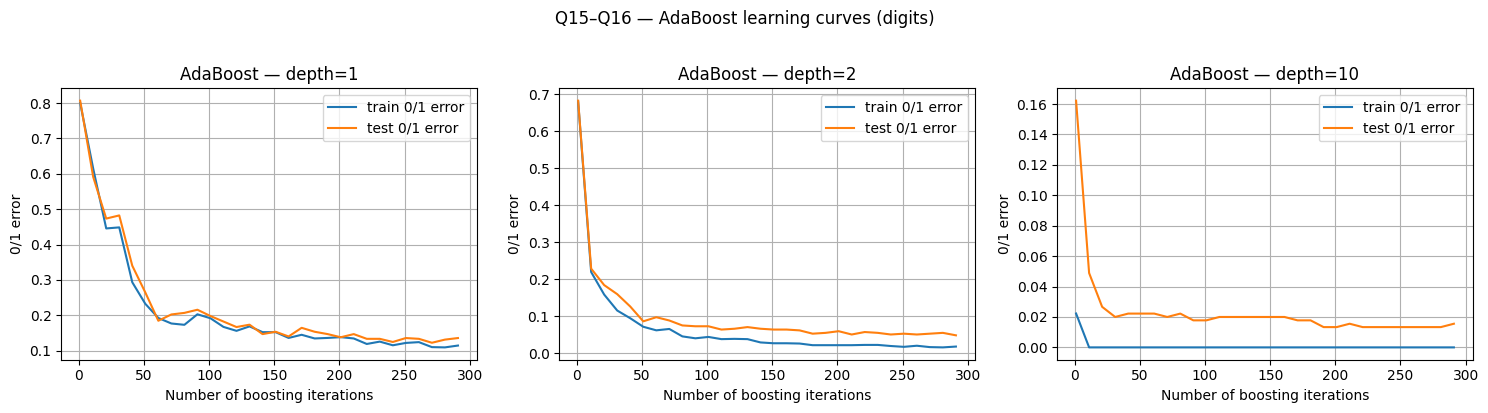

In [ ]:
# Train / test split (unique)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1, stratify=y
)

def learning_curves_adaboost(max_depth, M_values, learning_rate=1.0):
    train_err, test_err = [], []
    for M in M_values:
        base = DecisionTreeClassifier(max_depth=max_depth, random_state=1)
        ada = AdaBoostClassifier(
            estimator=base,         
            n_estimators=M,
            learning_rate=learning_rate,
            algorithm="SAMME",
            random_state=1
        )
        ada.fit(X_train, y_train)
        train_err.append(1 - accuracy_score(y_train, ada.predict(X_train)))
        test_err.append(1 - accuracy_score(y_test, ada.predict(X_test)))
    return np.array(train_err), np.array(test_err)

# Parameters
M_values = np.arange(1, 301, 10)
depths = [1, 2, 10]   

# Plot
plt.figure(figsize=(5 * len(depths), 4))

for i, depth in enumerate(depths, 1):
    tr, te = learning_curves_adaboost(depth, M_values)
    plt.subplot(1, len(depths), i)
    plt.plot(M_values, tr, label="train 0/1 error")
    plt.plot(M_values, te, label="test 0/1 error")
    plt.title(f"AdaBoost — depth={depth}")
    plt.xlabel("Number of boosting iterations")
    plt.ylabel("0/1 error")
    plt.grid(True)
    plt.legend()

plt.suptitle("Q15–Q16 — AdaBoost learning curves (digits)", y=1.02)
plt.tight_layout()
plt.show()

For shallow base learners (depth = 1), both training and test errors decrease progressively as the number of boosting iterations increases. The gap between training and test errors remains small, indicating good generalization properties. AdaBoost is able to reduce bias while keeping variance under control when using weak learners.

With slightly deeper trees (depth = 2), the training error decreases faster and reaches lower values, while the test error stabilizes at a lower level than for depth = 1. This setting provides a good trade-off between bias reduction and variance control, leading to improved generalization performance.

For deep trees (depth = 10), the training error drops to zero very quickly, showing that the model has enough capacity to perfectly fit the training data. However, the test error stabilizes at a non-zero level and does not improve further with additional boosting iterations. This behavior is characteristic of overfitting: increasing the complexity of the base learners amplifies variance, and boosting is no longer able to compensate for it.

These results illustrate that AdaBoost performs best with weak or moderately complex base learners, while using overly deep trees can lead to reduced generalization despite excellent training performance.

Q17) (Optional question) : Implement by yourself the AdaBoost algorithm.
Minimal Implementation Backbone (Adaboost (SAMME)

In [ ]:
def adaboost_samme(X, y, base_estimator, M=50, random_state=1):
    rng = np.random.RandomState(random_state)
    n = X.shape[0]
    classes = np.unique(y)
    K = len(classes)

    # weights
    w = np.ones(n) / n

    estimators = []
    alphas = []

    for m in range(M):
        est = clone(base_estimator)
        # weighted fit (DecisionTreeClassifier supports sample_weight)
        est.fit(X, y, sample_weight=w)
        y_pred = est.predict(X)

        err = np.sum(w * (y_pred != y))
        err = np.clip(err, 1e-12, 1 - 1e-12)

        alpha = np.log((1 - err) / err) + np.log(K - 1)  # SAMME
        w *= np.exp(alpha * (y_pred != y))
        w /= w.sum()

        estimators.append(est)
        alphas.append(alpha)

    return estimators, np.array(alphas)

def predict_samme(X, estimators, alphas):
    # weighted vote
    from collections import defaultdict
    preds = np.array([est.predict(X) for est in estimators])  # (M, n)
    n = X.shape[0]
    out = np.empty(n, dtype=preds.dtype)
    for i in range(n):
        scores = defaultdict(float)
        for m in range(len(estimators)):
            scores[preds[m, i]] += alphas[m]
        out[i] = max(scores, key=scores.get)
    return out

The proposed implementation corresponds to a minimal version of the AdaBoost algorithm (SAMME variant for multi-class classification). It includes the core components of boosting: initialization of sample weights, iterative training of weak learners with weighted samples, computation of classifier weights, and aggregation by weighted voting.

In its current form, the implementation allows one to understand how AdaBoost reweights observations to focus on misclassified samples and how successive weak learners are combined to form a strong classifier. It correctly reproduces the fundamental mechanism of boosting and its link with the minimization of the exponential loss.

However, this implementation remains intentionally simple. It does not include several practical improvements used in production implementations, such as early stopping, regularization via learning rate tuning, probability estimation (SAMME.R), or optimized handling of numerical stability. Moreover, it relies on decision trees that support sample weighting and does not exploit more advanced base learners.

The SAMME algorithm used here extends AdaBoost to multi-class classification by adapting the weight update and classifier contribution to the number of classes. In practice, more refined variants such as SAMME.R or gradient boosting methods are often preferred for improved performance and stability.